In [154]:
import numpy as np
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [174]:
plt.rcParams['font.family'] = 'IPAGothic'

In [58]:
def extract_words(word_seq, tag_seq):
    words_list = []
    words = []
    for word, tag in zip(word_seq, tag_seq):
        if tag == 'B' and words:
            words_list.append(''.join(words))
            words = [word]
        elif tag == 'B' or (tag == 'I' and words):
            words.append(word)
        elif words:
            words_list.append(''.join(words))
            words = []
            
    if words:
        words_list.append(''.join(words))
        
    return words_list

In [3]:
train_df = pd.read_pickle("../../data/train_IOB_repl_compound.pkl")
train_df.head(1)

,_id,label,sentence,title,words,repl_words,furigana_tag_seq,another_name_tag_seq,use_tag_seq,type_tag_seq,...,melting_tag_seq,boiling_tag_seq,rational_formula_tag_seq,h2,h3,h4,h5,h6,cat_production_headline,cat_raw_material_headline
0,10166,False,アンモニア (英: ammonia) は分子式が NH 3 で表される無機化合物。,アンモニア,"[アンモニア, (, 英, :, ammonia, ), は, 分子, 式, が, NH, ...","[[title-compound], (, 英, :, [title-compound], ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, B, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",NaN,NaN,NaN,NaN,NaN,2,2


In [216]:
def annotaions_in_section(section_df, _set=True):
    # 属性を指定
    annotaions = section_df.apply(lambda x: extract_words(x.words, x.production_tag_seq), axis=1).sum()
    if _set:
        annotaions = list(set(annotaions))
    
    return annotaions

In [217]:
heading_dist_df = pd.DataFrame()
for _id, entry in train_df.fillna('NO_HEADING').groupby('_id'):
    freq_dict = entry.groupby('h2').apply(
        lambda g: len(annotaions_in_section(g))
    ).to_dict()
    
    heading_dist_df = heading_dist_df.append(pd.DataFrame({_id: freq_dict}).T)

heading_dist_df = heading_dist_df.fillna(0).T

/usr/local/var/pyenv/versions/3.6.1/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [218]:
heading_entropy = \
heading_dist_df.apply(
    lambda x: x / x.sum()
).apply(
    lambda x: -x * np.log2(x)
).fillna(0).apply(
    lambda x: np.sum(x)
    , axis=1
)
heading_entropy.name = 'entropy'
heading_entropy.sort_values(ascending=False, inplace=True)

/usr/local/var/pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


In [219]:
h = heading_entropy.drop('NO_HEADING')
x = np.linspace(0, len(h), len(h))

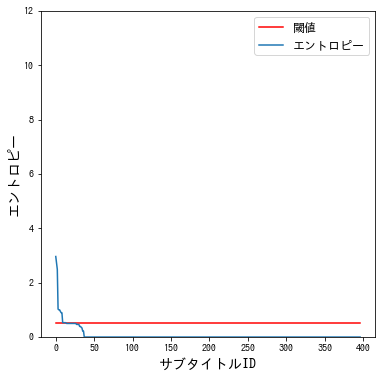

In [221]:
plt.figure(figsize=(6,6))
plt.xlabel("サブタイトルID", fontsize=14)
plt.ylabel("エントロピー", fontsize=14)
plt.ylim(0, 12)
plt.plot(x, [.5] * len(x), color='red')
plt.plot(x, h.values)
plt.legend(["閾値","エントロピー"], loc="best", fontsize=12)
plt.savefig("../../output/entropy_production.png")

In [136]:
heading_entropy.to_pickle("../../data/annotaions_entropy_in_section_production.pkl")